# Multiple linear regression model
### Let's mimic the process of building our trading model of SPY, base on the historical data of different stock markets

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import all stock market data into DataFrame
aord = pd.DataFrame.from_csv('../data/indice/ALLOrdinary.csv')
nikkei = pd.DataFrame.from_csv('../data/indice/Nikkei225.csv')
hsi = pd.DataFrame.from_csv('../data/indice/HSI.csv')
daxi = pd.DataFrame.from_csv('../data/indice/DAXI.csv')
cac40 = pd.DataFrame.from_csv('../data/indice/CAC40.csv')
sp500 = pd.DataFrame.from_csv('../data/indice/SP500.csv')
dji = pd.DataFrame.from_csv('../data/indice/DJI.csv')
nasdaq = pd.DataFrame.from_csv('../data/indice/nasdaq_composite.csv')
spy = pd.DataFrame.from_csv('../data/indice/SPY.csv')

## Step 1: Data Munging

In [4]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model

indicepanel = pd.DataFrame(index=spy.index)
indicepanel['spy'] = spy['Open'].shift(-1) - spy['Open']
indicepanel['spy_lag1'] = indicepanel['spy'].shift(1)
indicepanel['sp500'] = sp500['Open'] - sp500['Open'].shift(1)
indicepanel['nasdaq'] = nasdaq['Open'] - nasdaq['Open'].shift(1)
indicepanel['dji'] = dji['Open'] - dji['Open'].shift(1)

indicepanel['cac40'] = cac40['Open'] - cac40['Open'].shift(1)
indicepanel['daxi'] = daxi['Open'] - daxi['Open'].shift(1)

indicepanel['aord'] = aord['Close'] - aord['Open']
indicepanel['hsi'] = hsi['Close'] - hsi['Open']
indicepanel['nikkei'] = nikkei['Close'] - nikkei['Open']

indicepanel['Price'] = spy['Open']

In [5]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        29
daxi        343
aord        527
hsi         407
nikkei      434
Price         0
dtype: int64

In [6]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [7]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [8]:
# save this indicepanel for part 4.5
path_save = '../data/indice/indicepanel.csv'
indicepanel.to_csv(path_save)

In [9]:
print(indicepanel.shape)

(2677, 11)


## Step 2: Data Spliting

In [10]:
#split the data into (1)train set and (2)test set

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


## Step 3: Explore the train data set

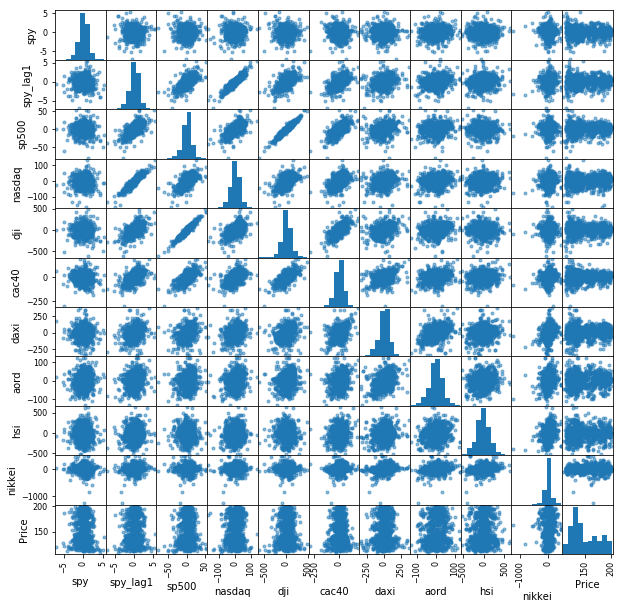

In [11]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association

from pandas.tools.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

## Step 4: Find the top five correlated indice to SPY

In [10]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
corr_array_sorted = np.abs(corr_array).sort_values(ascending=False)[1:] # We ignore the first highest, which is SPY, the correlation to itself is always 1, the highest.
print(corr_array_sorted[:5])

aord      0.075872
cac40     0.055079
nikkei    0.043934
dji       0.037097
daxi      0.036091
Name: spy, dtype: float64


In [11]:
formula = 'spy~aord+cac40+nikkei+dji+daxi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.138
Date:                Wed, 24 Oct 2018   Prob (F-statistic):            0.00812
Time:                        04:10:41   Log-Likelihood:                -1644.8
No. Observations:                1000   AIC:                             3302.
Df Residuals:                     994   BIC:                             3331.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0858      0.040      2.150      0.032       0.007       0.164
aord           0.0041      0.001      3.340      0.001       0.002       0.006
cac40         -0.0014      0.001     -1.101      0.271      -0.004       0.001
nikkei        -0.0005      0.000     -1.564      0.118      -0.001       0.000
dji        -6.939e-05      0.000     -0.140      0.889      -0.001       0.001
daxi          -0.0006      0.001     -1.035      0.301      -0.002       0.001
==============================================================================
Omnibus:                       97.543   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              286.548
Skew:                          -0.487   Prob(JB):                     5.98e-63
Kurtosis:                       5.435   Cond. No.                         130.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 5: Make prediction

In [12]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


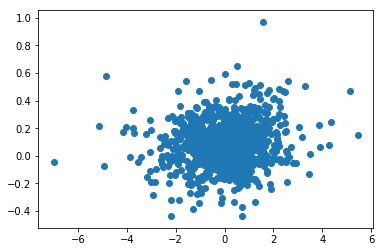

In [13]:
plt.scatter(Train['spy'], Train['PredictedY'])

## Step 6: Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics - **RMSE**, **Adjusted $R^2$ **

In [14]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'].mean())**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [15]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [16]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 5, 'spy')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Train,Test
R2,0.010585,0.008850
RMSE,1.267109,1.742531


We can see that the adjusted $R^2$ drops and the RMSE increases in test. It is not as consistent as the model we demostrated in the lecture.